Again we do some imports



In [12]:

import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
%matplotlib inline

Setting up equations and parameters

In [13]:
r = 0.05 #interest rate
mu = 0.02 #drift
sigma = 0.25 #diffusion
gamma = 0.2 #tax rate
X_0 = 1 #initial dividend
q = 0.1 #cost of issuing debt
alpha = 0.15 #default cost

beta1 = (sigma**2 / 2 - mu + sym.sqrt((mu - sigma**2 / 2)**2 + 2 * sigma**2 * r)) / sigma**2
beta2 = (sigma**2 / 2 - mu - sym.sqrt((mu - sigma**2 / 2)**2 + 2 * sigma**2 * r)) / sigma**2

xstar = sym.Symbol('x^*')
xdoverc0 = sym.Symbol('\\frac{x_D}{c_0}')
xroverc0 = sym.Symbol('\\frac{x_R}{c_0}')
def AD(x, xl, xh):
    return -(x/xl)**beta1 * ((xl/xh)**(beta2 - beta1) - 1)**(-1) + (x/xl)**beta2 * (1 - (xl/xh)**(beta1 - beta2))**(-1)

Sequity = (xstar/(r - mu) - 1/r) * (1 - gamma) + (xstar/xdoverc0)**beta2 * (1/r - xdoverc0/(r - mu)) * (1 - gamma)

D = 1 / r + AD(xstar, xdoverc0, xroverc0) * (-1 / r + (1 - alpha) * (1 - gamma) * xdoverc0 / (r - mu)) \
    + 1 / r * AD(xstar, xroverc0, xdoverc0)
S = (xstar / (r - mu) - 1 / r + AD(xstar, xdoverc0, xroverc0) * (1 / r - xdoverc0 / (r - mu))) * (1 - gamma) \
    + AD(xstar, xroverc0, xdoverc0) * ((1 / r - xroverc0 / (r - mu)) * (1 - gamma) - 1/r + (1 - q)*D + Sequity)

Sprime = S.diff(xstar)
Dprime = D.diff(xstar)
Sequityprime = Sequity.diff(xstar)

In [14]:
eq1 = Sprime.subs(xstar, xdoverc0)
eq2 = (1 - q) * D - (1 - q) * xstar * Dprime - xstar * Sequityprime + Sequity
eq3 = Sprime.subs(xstar, xroverc0) - (1 - q) * Dprime - Sequityprime

In [ ]:
sym.nsolve((eq1, eq2, eq3), (xstar, xdoverc0, xroverc0), (0.32, 1, 20))

This step took too long. There could well be some mistake either in my calculation or coding.
Below is the code for Q3. I only solve Q3.1 with pseudo barrier of default, refinance, and optimal ratio.
Q3.2 is almost the same, with only a slight change of those barriers and a new way to compute company value.

Writing code for Q3

In [15]:
N = 10000
period = 300
optimalratio = 0.5 #optimal interest coverage ratio
refinance = 2 #refinancing boundary
default = 0.2 #default boundary
dt = 0.01 #time interval

def simpath(xinit, refinance, default, optimalratio):
    W = np.random.standard_normal(size=period)
    X = np.empty(period)
    C = np.empty(period)
    ratio = np.empty(period)
    X[0] = xinit
    C[0] = xinit * optimalratio
    ratio[0] = X[0] / C[0]

    for t in range(period - 1):
        X[t+1] = X[t] * np.exp((mu - 0.5*sigma**2)*dt + sigma*W[t+1])
        if X[t+1] / C[t] >= refinance:
            C[t+1] = X[t+1] * optimalratio
        elif X[t+1] / C[t] <= default:
            X[t+1:] = 0
            C[t+1:] = C[t]
            ratio[t+1:] = 0
            #plt.plot(range(300), X)
            #plt.show()
            return X, C, ratio
        else:
            C[t+1] = C[t]
        ratio[t+1] = X[t+1] / C[t+1]
    #plt.plot(range(300), X)
    #plt.show()
    return X, C, ratio

So the leverage ratio is $\frac{(1 - q) D(X_t)}{(1 - q) D(X_t) + S(X_t)}$ in question 2.1.
We then compute $D(X_t)$ and $S(X_t)$

In [16]:
def leverage_ratio(x, c):
    xD = beta2 / (beta2 - 1) * (r - mu) / r * c
    S = (x / (r - mu) - c / r) * (1 - gamma) + (x / xD)**beta2*(-xD/(r - mu) + c/r) * (1 - gamma)
    D = c / r - (x / xD)**beta2 * c / r + (x / xD)**beta2 * (1 - alpha) * (1 - gamma) * xD / (r - mu)
    return (1 - q) * D / ((1 - q) * D + S)

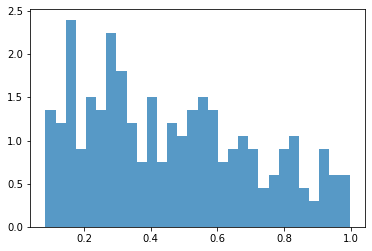

In [17]:
sample = np.empty(N)
for n in range(N):
    X, C, ratio = simpath(1, 8, 0.3, 1)
    if X[-1] > 0:
        sample[n] = leverage_ratio(X[-1], C[-1])
    else:
        sample[n] = 0


fig, ax = plt.subplots()
ax.hist(sample[sample > 0], bins=30, density=True, histtype='bar', alpha=0.75)
plt.show()

Average leverage ratio:

In [18]:
np.mean(sample[sample > 0])

0.46281684605943096